In [1]:
from flow_computation import flow_computation
from random_vessel_generator import random_vessel_generator
from first_stage_frlm import first_stage_frlm
from generate_network_nodes import generate_network
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
def calc_servable_fraction(load, r, additional_nodes=0):
    """abc
    Parameters
    ----------
    load:float
        Percentage of vessels on the network compared to the 2021 total.

    r:int
        Range of a vessel.

    additional_nodes: int
        Number of additional nodes that should be inserted into the original network.
    """
    G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
    df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
    df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
    path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
    paths = pickle.load(open('data/final_paths.p', "rb"))

    # if additional nodes need to be considered, update G, paths and inserted accordingly
    inserted = []
    if additional_nodes != 0:
        G, paths, inserted = generate_network(G, paths, additional_nodes)

    # generate random data
    df_random = random_vessel_generator(df_ivs, load)
    flows = flow_computation(df_random)
    

    # execute first stage, with or without additional nodes
    df_b, df_g, df_eq_fq, feasible_combinations = first_stage_frlm(r, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h,
                                            additional_nodes=inserted)
    # determine total flow on network
    total_flow = sum(flows.values())

    # determine maximal supportable flow only limited by range
    max_supported = {i:flows[i] for i in flows if len(feasible_combinations[i])>0}
    max_supported = sum(max_supported.values())

    # calculate this as a fraction of the total flow
    serveable_fraction = (max_supported/total_flow)
    #
    # add_nodes_route = {}
    # needed_nodes = {}
    # for route, combis in feasible_combinations.items():
    #     additional_nodes_necessary = True
    #     for combi in combis:
    #         if all (len(str(i))>4 for i in combi):
    #             additional_nodes_necessary = False
    #             break
    #
    #     add_nodes_route[route] = additional_nodes_necessary
    #     if additional_nodes_necessary:
    #         for combi in combis:
    #             needed_nodes[route] = []
    #             for node in combi:
    #                 sub_l=[]
    #                 if len(node)<4:
    #                     sub_l.append(node)
    #                     needed_nodes[route] += sub_l
    #
    # extra_nodes_used = list(needed_nodes.values())
    # extra_nodes_used = [x for xs in extra_nodes_used for x in xs]
    # extra_nodes_used = list(set(extra_nodes_used))
    # extra_nodes_used = len(extra_nodes_used)

    return additional_nodes, serveable_fraction

In [3]:
%%time
additional_nodes, serveable_fraction = calc_servable_fraction(1, 150000, 20)

CPU times: total: 5.88 s
Wall time: 5.86 s


In [ ]:
%%time
plot_dict = {'r':[], 'additional_nodes':[], 'add_nodes_in_routes':[], 'servable_fraction':[]}
for r in np.arange(40000, 150000, 10000):
    for add_nodes in np.arange(0, 101, 10):
        additional_nodes, extra_nodes_used, serveable_fraction = calc_servable_fraction(1, r, 100, 5, 5, add_nodes)
        plot_dict['r'].append(r)
        plot_dict['additional_nodes'].append(add_nodes)
        # plot_dict['add_nodes_in_routes'].append(extra_nodes_used)
        plot_dict['servable_fraction'].append(serveable_fraction)
        print(r, add_nodes)


In [ ]:
coverage_range_nodes = pd.DataFrame.from_dict(plot_dict)

In [ ]:
coverage_range_nodes

In [ ]:
plot_dict1 = pickle.load(open('data/plot_dict_0_100_till150.p', 'rb'))
plot_dict2 = pickle.load(open('data/plot_dict_0_70_175-250.p', 'rb'))

In [12]:
plot_dict1 = pd.DataFrame.from_dict(plot_dict1)
plot_dict2 = pd.DataFrame.from_dict(plot_dict2)

In [17]:
plot_dict = pd.concat([plot_dict1, plot_dict2])

In [19]:
plot_dict

,r,additional_nodes,add_nodes_in_routes,servable_fraction
0,25000,0,0,0.109797
1,25000,10,0,0.104996
2,25000,20,0,0.110104
3,25000,30,2,0.118718
4,25000,40,5,0.134321
...,...,...,...,...
27,250000,30,5,0.999272
28,250000,40,4,0.999382
29,250000,50,5,0.999319
30,250000,60,5,0.999478


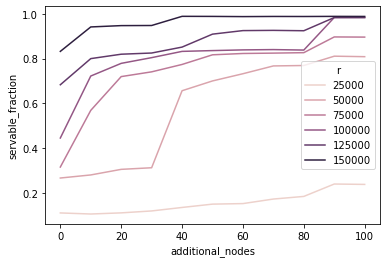

In [22]:
sns.lineplot(x='additional_nodes', y='servable_fraction', hue='r', data=plot_dict1)
plt.show()

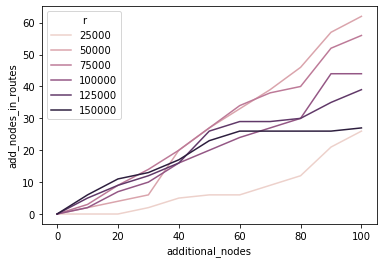

In [25]:
sns.lineplot(x='additional_nodes', y='add_nodes_in_routes', hue='r', data=plot_dict1)
plt.show()

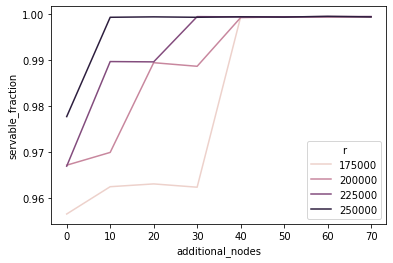

In [26]:
sns.lineplot(x='additional_nodes', y='servable_fraction', hue='r', data=plot_dict1)
plt.show()

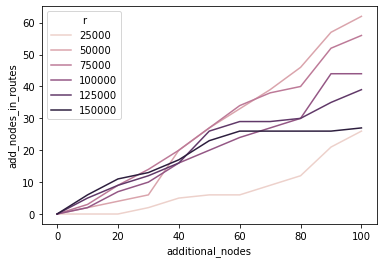

In [27]:
sns.lineplot(x='additional_nodes', y='add_nodes_in_routes', hue='r', data=plot_dict1)
plt.show()

## New

In [1]:
import networkx as nx
import pickle
import pandas as pd
import geopy.distance
import matplotlib.pyplot as plt
from generate_network import generate_network
pd.options.mode.chained_assignment = None  # default='warn'

G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
paths = pickle.load(open('data/final_paths.p', "rb"))

df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

r= 70000

In [2]:
G, paths, inserted = generate_network(G, paths, r)

There were 25 nodes added, the longest remaining link is now: 34588.667517419424


In [3]:
from determine_additional_nodes import determine_additional_nodes

additional_intersections = determine_additional_nodes(G, df_h, r)


4 intersections were added


In [4]:
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

pos_dict = {}
for node in G.nodes:
    pos_dict[node] = (G.nodes[node]['X'], G.nodes[node]['Y'])

In [8]:
edge_list1 = []
for i in range(len(paths[('NLAMS', 'NLOSS', 0)])-1):
    edge_list1.append((paths[('NLAMS', 'NLOSS', 0)][i],paths[('NLAMS', 'NLOSS', 0)][i+1]))

In [10]:
edge_list1

[('8866763', '8866429'),
 ('8866429', '8863656'),
 ('8863656', '8863272'),
 ('8863272', '8866747'),
 ('8866747', '8863796'),
 ('8863796', '8862592'),
 ('8862592', '8864384'),
 ('8864384', '8865887'),
 ('8865887', '8864837'),
 ('8864837', '8865846'),
 ('8865846', '8866095'),
 ('8866095', '8860631'),
 ('8860631', '8862340'),
 ('8862340', '8862202'),
 ('8862202', '8861996'),
 ('8861996', '8865631'),
 ('8865631', '8865735'),
 ('8865735', '8865119'),
 ('8865119', '8860920'),
 ('8860920', '8862570')]

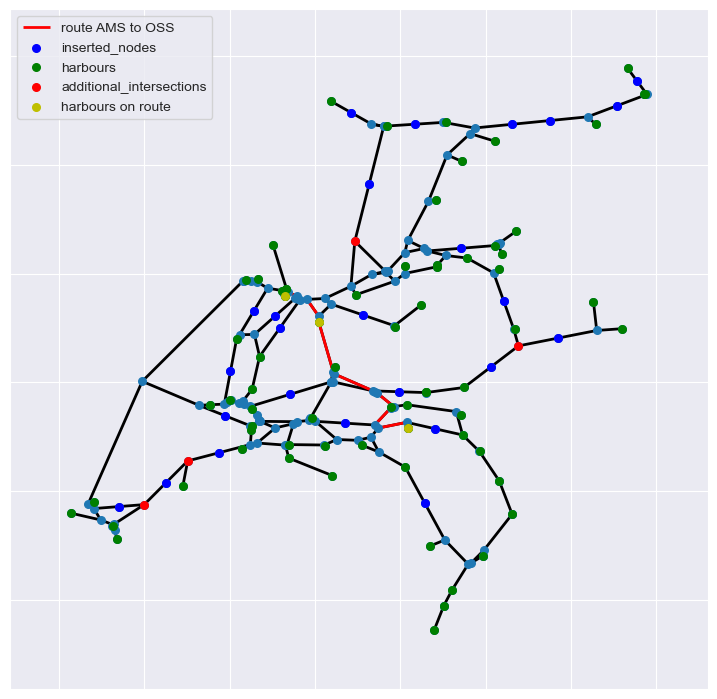

In [20]:
fig, ax = plt.subplots(figsize=(9,9), dpi=100)
nx.draw_networkx_edges(G, pos_dict, width=2, ax=ax)
nx.draw_networkx_edges(G, pos_dict,edge_list1, width=2, edge_color='r', label='route AMS to OSS')
nx.draw_networkx_nodes(G, pos_dict, node_size=30)
nx.draw_networkx_nodes(G, pos_dict, inserted, node_size=30, node_color = 'b', label = 'inserted_nodes')
nx.draw_networkx_nodes(G, pos_dict, list(df_h.harbour_node), node_size=30, node_color = 'g', label='harbours')
nx.draw_networkx_nodes(G, pos_dict, list(additional_intersections), node_size=30, node_color = 'r', label='additional_intersections')
nx.draw_networkx_nodes(G, pos_dict, ['8866763', '8864837', '8862570'], node_size=30, node_color = 'y', label='harbours on route')
plt.legend()
plt.show()